## Importing Relevant Libraries

In [1]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
#import nltk 

# %matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

In [2]:
data = pd.read_csv('nlp-getting-started/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Analysis

*   there are 7613 data points.
*   **99.198739%** of the data has **keywords**.
*   **66.73%** of the data has **location** points
*   the top key word used to extract tweets is **fatalities**.
*   data is ordered in terms of keyword used to extact the tweet from twitter.

### Decisions 

- the most important columns are the text and target columns
- the text column contains information about the tweet
- the keyword column can be discarded because the keyword appears within the tweet itself.
*   keyword and location features were dropped as they add no significant value to the model performance.


### Data Cleaning

In [3]:
#### Functions for cleaning and processing data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')

porter =  PorterStemmer()

def sentenceStemmer(text):
	words = word_tokenize(text)
	corpus = []
	for word in words:
		corpus.append(porter.stem(word))
		corpus.append(" ")
	#end for
	return "".join(corpus)
#end sentenceStemmer

#remove emojis from text
def remove_emoji(text):
    tweet = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return tweet.sub(r'', text)
#end remove_emoji

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
#end clean_text

# Tockenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
#end tokenization

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
#end remove_stopwords

# turn tokenized data into string
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
#end listToString

def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "tennessee weather", tweet)
    tweet = re.sub(r"azwx", "arizona weather", tweet)  
    tweet = re.sub(r"alwx", "alabama weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "georgia weather", tweet)  
    tweet = re.sub(r"scwx", "south carolina weather", tweet)  
    tweet = re.sub(r"cawx", "california weather", tweet)
    tweet = re.sub(r"usnwsgov", "united states national weather service", tweet) 
    tweet = re.sub(r"MH370", "malaysia airlines flight 370", tweet)
    tweet = re.sub(r"okwx", "oklahoma city weather", tweet)
    tweet = re.sub(r"arwx", "arkansas weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am i right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"usagov", "usa government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"ph0tos", "photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"trfc", "traffic", tweet)
    tweet = re.sub(r"windStorm", "wind storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"traumatised", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"radiation%20emergency","radiation emergency", tweet)
    tweet = re.sub(r"forest%20fire","forest fire", tweet)
    tweet = re.sub(r"war%Ozone","war zone", tweet)
    tweet = re.sub(r"bush%20fires","bush fires", tweet)
    tweet = re.sub(r"burning%20buildings","burning buildings", tweet)
    tweet = re.sub(r"first%20responders","first responders", tweet)
    tweet = re.sub(r"irandeal", "iran deal", tweet)
    tweet = re.sub(r"arianagrande", "ariana grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"rondarousey", "ronda rousey", tweet)     
    tweet = re.sub(r"mtvhottest", "mtv hottest", tweet)
    tweet = re.sub(r"trapmusic", "trap music", tweet)
    tweet = re.sub(r"prophetmuhammad", "prophet Mmuhammad", tweet)
    tweet = re.sub(r"PantherAttack", "panther attack", tweet)
    tweet = re.sub(r"strategicpatience", "strategic patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"idps:", "internally displaced people :", tweet)
    tweet = re.sub(r"artistsUnited", "artists united", tweet)
    tweet = re.sub(r"claytonBryant", "clayton bryant", tweet)
    tweet = re.sub(r"uk", "united kingdom", tweet)
    tweet = re.sub(r"usa", "united states of america", tweet)
    tweet = re.sub(r"ny", "new york", tweet)
    tweet = re.sub(r"newcastleupontyne", "newcastle upon tyne", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"time2015", "time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"livingsafely", "living safely", tweet)
    tweet = re.sub(r"fifa16", "fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"undergroundrailraod", "underground railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"mudslide", "mud slide", tweet)
    tweet = re.sub(r"nosurrender", "no surrender", tweet)
    tweet = re.sub(r"notexplained", "not explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"londonfire", "london fire", tweet)
    tweet = re.sub(r"kotaweather", "kota weather", tweet)
    tweet = re.sub(r"luchaunderground", "lucha underground", tweet)
    tweet = re.sub(r"koin6news", "koin 6 news", tweet)
    tweet = re.sub(r"liveOnK2", "live on K2", tweet)
    tweet = re.sub(r"9newsgoldcoast", "9 news gold coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "david cameron", tweet)
    tweet = re.sub(r"peterjukes", "peter jukes", tweet)
    tweet = re.sub(r"mikeparractor", "michael parr", tweet)
    tweet = re.sub(r"4playthursdays", "foreplay thursdays", tweet)
    tweet = re.sub(r"tgf2015", "tonti town grape festival", tweet)
    tweet = re.sub(r"realmandyrain", "mandy rain", tweet)
    tweet = re.sub(r"graysondolan", "grayson dolan", tweet)
    tweet = re.sub(r"apollobrown", "apollo brown", tweet)
    tweet = re.sub(r"saddlebrooke", "saddle brooke", tweet)
    tweet = re.sub(r"tontitowngrape", "tonti town grape", tweet)
    tweet = re.sub(r"abbswinston", "abbs winston", tweet)
    tweet = re.sub(r"shaunKing", "sshaun king", tweet)
    tweet = re.sub(r"meekmill", "meek mill", tweet)
    tweet = re.sub(r"tornadogiveaway", "tornado giveaway", tweet)
    tweet = re.sub(r"grupdates", "gr updates", tweet)
    tweet = re.sub(r"southdowns", "south downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "calgary weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "ed sheeran", tweet)
    tweet = re.sub(r"trueHeroes", "true heroes", tweet)
    tweet = re.sub(r"complexmag", "complex magazine", tweet)
    tweet = re.sub(r"theadvocatemag", "the advocate magazine", tweet)
    tweet = re.sub(r"cityofcalgary", "city of calgary", tweet)
    tweet = re.sub(r"ebolaoutbreak", "ebola outbreak", tweet)
    tweet = re.sub(r"summerfate", "summer fate", tweet)
    tweet = re.sub(r"ramag", "royal academy magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"modiministry", "modi ministry", tweet)
    tweet = re.sub(r"taxiways", "taxi ways", tweet)
    tweet = re.sub(r"calum5sos", "calum hood", tweet)
    tweet = re.sub(r"jamesmelville", "james melville", tweet)
    tweet = re.sub(r"jamaicaobserver", "jamaica observer", tweet)
    tweet = re.sub(r"tweetlikeitsseptember11th2001", "tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"blacklivesmatter", "black lives matter", tweet)
    tweet = re.sub(r"nasahurricane", "nasa hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"typhoon-devastated", "typhoon devastated", tweet)
    tweet = re.sub(r"meat-loving", "meat loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"lakecounty", "lake county", tweet)
    tweet = re.sub(r"beingauthor", "being author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thanku", "thank you", tweet)
    tweet = re.sub(r"itunesmusic", "itunes music", tweet)
    tweet = re.sub(r"offensivecontent", "offensive content", tweet)
    tweet = re.sub(r"worstsummerjob", "worst summer job", tweet)
    tweet = re.sub(r"harrybecareful", "harry be careful", tweet)
    tweet = re.sub(r"nasasolarsystem", "nasa solar system", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"kurtschlichter", "kurt schlichter", tweet)
    tweet = re.sub(r"throwingknifes", "throwing knives", tweet)
    tweet = re.sub(r"godsLove", "god's love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"nestleindia", "nestle india", tweet)
    tweet = re.sub(r"realdonaldtrump", "donald trump", tweet)
    tweet = re.sub(r"davidvonderhaar", "david vonderhaar", tweet)
    tweet = re.sub(r"ceciltheLion", "cecil the lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"gopdebate", "gop debate", tweet)
    tweet = re.sub(r"rickperry", "rick perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"newsintweets", "news in tweets", tweet)
    tweet = re.sub(r"viralspell", "viral spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinrussia", "volcano in russia", tweet)
    tweet = re.sub(r"zippednews", "Zipped news", tweet)
    tweet = re.sub(r"michelebachman", "michele bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"kerricktrial", "kerrick trial", tweet)
    tweet = re.sub(r"abstorm", "alberta storm", tweet)
    tweet = re.sub(r"beyhive", "beyonce hive", tweet)
    tweet = re.sub(r"rockyfire", "rocky fire", tweet)
    tweet = re.sub(r"listen/buy", "listen or buy", tweet)
    tweet = re.sub(r"artistsunited", "artists united", tweet)
    tweet = re.sub(r"engvsaus", "england vs australia", tweet)
    tweet = re.sub(r"scottwalker", "scott walker", tweet)
    tweet = re.sub(r"africanbaze", "african baze", tweet)
    tweet = re.sub(r"engineshed", "engine shed", tweet)
    tweet = re.sub(r"newsnigeria", "nigeria news", tweet)
    return tweet
#end clean

[nltk_data] Downloading package punkt to /home/patrick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/patrick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
modified_data = data.copy()
# Removing duplicates
modified_data = modified_data.drop_duplicates(subset=['text'])

modified_data['text'] = modified_data['text'].apply(lambda x: clean_text(x))
modified_data['text'] = modified_data['text'].apply(lambda x: tokenization(x.lower()))
modified_data['text'] = modified_data['text'].apply(lambda x: remove_stopwords(x))
modified_data['text'] = modified_data['text'].apply(lambda x: listToString(x))
modified_data['text'] = modified_data['text'].apply(lambda x: remove_emoji(x))
modified_data['text'] = modified_data['text'].apply(lambda x: clean(x))
modified_data['text'] = modified_data['text'].apply(lambda x: sentenceStemmer(x))
modified_data

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu shelter place order expect,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1
...,...,...,...,...,...
7604,10863,NaN,NaN,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,NaN,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,NaN,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1


In [6]:
# New dataframe with of missing location features
df_new = modified_data.copy()
bool_series = pd.isnull(df_new["location"])
df1 = df_new[bool_series]
df1

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu shelter place order expect,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1
...,...,...,...,...,...
7604,10863,NaN,NaN,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,NaN,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,NaN,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1


In [7]:
df_new.dropna(subset=['location'], inplace=True)
usa = df1[:497]
new_york = df1[498:994]
united_states = df1[995:1490]
london = df1[1491:1986]
canada = df1[1987:2482]

# filling missing values with top 5 most used locations
usa['location'].fillna('usa', inplace=True)
new_york['location'].fillna('new york', inplace=True)
united_states['location'].fillna('united states', inplace=True)
london['location'].fillna('london', inplace=True)
canada['location'].fillna('canada', inplace=True)

# Merging the dataframes
df2 = usa.append(new_york)
df3 = df2.append(united_states)
df4 = df3.append(london)
df5 = df4.append(canada)
final_df = df_new.append(df5)
final_df

/home/patrick/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesal market ablaz,1
32,49,ablaze,Est. September 2012 - Bristol,alway tri bring heavi metal rt,0
33,50,ablaze,AFRICA,african baze break nigeria news flag set ablaz aba,1
34,52,ablaze,"Philadelphia, PA",cri set ablaz,0
35,53,ablaze,"London, UK",plu side look sky last night ablaz,0
...,...,...,...,...,...
7604,10863,NaN,canada,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,canada,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,canada,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,canada,two giant crane hold bridg collaps nearbi home,1


In [9]:
final_df['location'] = final_df['location'].apply(lambda x: clean_text(x))
final_df['location'] = final_df['location'].apply(lambda x: tokenization(x.lower()))
final_df['location'] = final_df['location'].apply(lambda x: remove_stopwords(x))
final_df['location'] = final_df['location'].apply(lambda x: listToString(x))
final_df['location'] = final_df['location'].apply(lambda x: remove_emoji(x))
final_df['location'] = final_df['location'].apply(lambda x: clean(x))
final_df['location'] = final_df['location'].apply(lambda x: sentenceStemmer(x))
final_df

,id,keyword,location,text,target
31,48,ablaze,birmingham,bbcmtd wholesal market ablaz,1
32,49,ablaze,est septemb bristol,alway tri bring heavi metal rt,0
33,50,ablaze,africa,african baze break nigeria news flag set ablaz aba,1
34,52,ablaze,philadelphia pa,cri set ablaz,0
35,53,ablaze,london unit kingdom,plu side look sky last night ablaz,0
...,...,...,...,...,...
7604,10863,NaN,canada,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,canada,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,canada,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,canada,two giant crane hold bridg collaps nearbi home,1


In [10]:
df = final_df.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[6])
print(X_train[6])

someon mention gansey firem bust brick wall seven differ build 
[266, 1057, 4481, 4482, 2456, 4483, 804, 1537, 805, 29]


### Model

In [40]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from keras import layers

embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(32, kernel_initializer='he_normal', activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           581350    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 583,015
Trainable params: 583,015
Non-trainable params: 0
_________________________________________________________________


In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [15]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_model = model.to_json()
with open('./NN_Models/keras_embed_mlp_model.json', 'w') as json_file:
    json_file.write(keras_embed_model)

model.save_weights('./NN_Models/keras_embed_mlp_model.h5')

print('saved model!')

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
600/600 [==============================] - 9s 14ms/step - loss: 0.5570 - accuracy: 0.7158 - precision: 0.8054 - recall: 0.4442 - val_loss: 0.4438 - val_accuracy: 0.8013 - val_precision: 0.8048 - val_recall: 0.6917
Epoch 2/50
600/600 [==============================] - 8s 14ms/step - loss: 0.3370 - accuracy: 0.8595 - precision: 0.8627 - recall: 0.7993 - val_loss: 0.4709 - val_accuracy: 0.7827 - val_precision: 0.7366 - val_recall: 0.7460
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


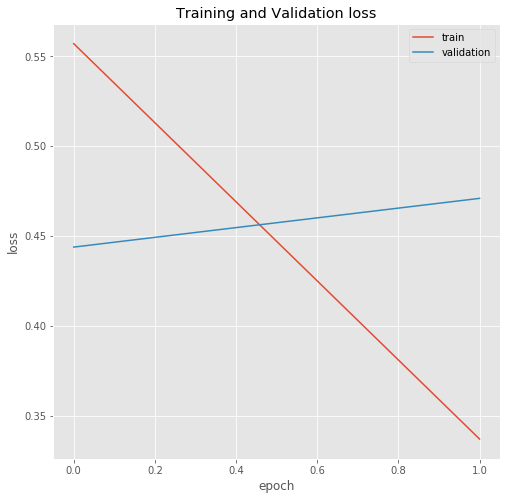

In [16]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [17]:
model.evaluate(X_train, y_train, verbose=False)

[0.20526431500911713,
 0.9321553707122803,
 0.9273301959037781,
 0.9132633209228516]

### Testing Model

In [18]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


,Negative,Positive
Negative,707,167
Positive,159,467


In [19]:
results

,Value
Accuracy,0.782667
Precision,0.736593
FPR,0.191076
Recall,0.746006
F1,0.741270


### Summary of Keras Embedding Layer
- The highest achievable accuracy is 77%.
- F1 score is 0.7.
- Recall and Precision are 65% and 77% respectively.
- Validation loss never goes below ~0.34.
- Best performance is at batch size of 32.
- The base model seems to be better than this in terms of accuracy.

# SimpleRNN+keras embedding layer

In [21]:
df = final_df.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [22]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [23]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,SpatialDropout1D

embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           581350    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 128)          22912     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [24]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=32,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

keras_embed_RNN_model = model.to_json()
with open('./NN_Models/keras_embed_RNN_model.json', 'w') as json_file:
    json_file.write(keras_embed_RNN_model)

model.save_weights('./NN_Models/keras_embed_RNN_model.h5')

print('saved model!')

Epoch 1/30
169/169 [==============================] - 5s 32ms/step - loss: 0.6441 - accuracy: 0.6381 - val_loss: 0.5450 - val_accuracy: 0.7367
Epoch 2/30
169/169 [==============================] - 5s 28ms/step - loss: 0.4630 - accuracy: 0.8063 - val_loss: 0.4966 - val_accuracy: 0.7750
Epoch 3/30
169/169 [==============================] - 5s 29ms/step - loss: 0.3512 - accuracy: 0.8622 - val_loss: 0.5168 - val_accuracy: 0.7600
Epoch 4/30
169/169 [==============================] - 5s 27ms/step - loss: 0.2829 - accuracy: 0.8952 - val_loss: 0.5518 - val_accuracy: 0.7483
Epoch 5/30
169/169 [==============================] - 5s 27ms/step - loss: 0.2194 - accuracy: 0.9196 - val_loss: 0.6797 - val_accuracy: 0.7567
Epoch 6/30
169/169 [==============================] - 5s 28ms/step - loss: 0.1726 - accuracy: 0.9387 - val_loss: 0.6294 - val_accuracy: 0.7533
Epoch 7/30
169/169 [==============================] - 5s 28ms/step - loss: 0.1416 - accuracy: 0.9478 - val_loss: 0.7212 - val_accuracy: 0.7650

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


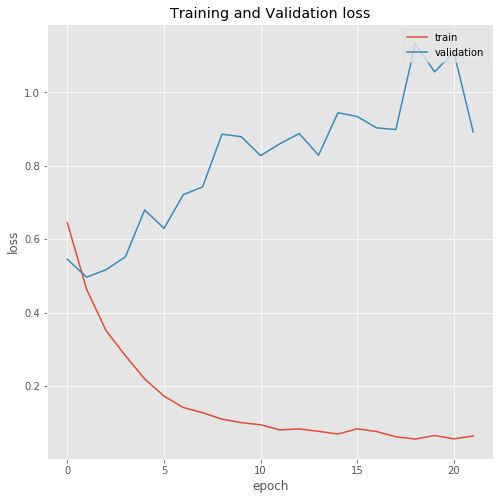

In [25]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [26]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,705,169
Positive,194,432


In [27]:
results

,Value
Accuracy,0.758000
Precision,0.718802
FPR,0.193364
Recall,0.690096
F1,0.704156


# LSTM+keras embedding layer

In [28]:
df = final_df.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

In [29]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [30]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D, Bidirectional

embedding_dim = 64
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 64)           744128    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          98816     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [31]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=64,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])

lstm_keras_embed_model = model.to_json()
with open('./NN_Models/lstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(lstm_keras_embed_model)

model.save_weights('./NN_Models/lstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/50
85/85 [==============================] - 9s 104ms/step - loss: 0.5698 - accuracy: 0.6879 - val_loss: 0.4902 - val_accuracy: 0.7817
Epoch 2/50
85/85 [==============================] - 8s 91ms/step - loss: 0.3709 - accuracy: 0.8553 - val_loss: 0.4541 - val_accuracy: 0.8000
Epoch 3/50
85/85 [==============================] - 8s 94ms/step - loss: 0.2866 - accuracy: 0.8929 - val_loss: 0.4635 - val_accuracy: 0.7933
Epoch 4/50
85/85 [==============================] - 8s 95ms/step - loss: 0.2479 - accuracy: 0.9144 - val_loss: 0.5437 - val_accuracy: 0.7833
Epoch 5/50
85/85 [==============================] - 7s 83ms/step - loss: 0.2126 - accuracy: 0.9305 - val_loss: 0.6791 - val_accuracy: 0.7850
Epoch 00005: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


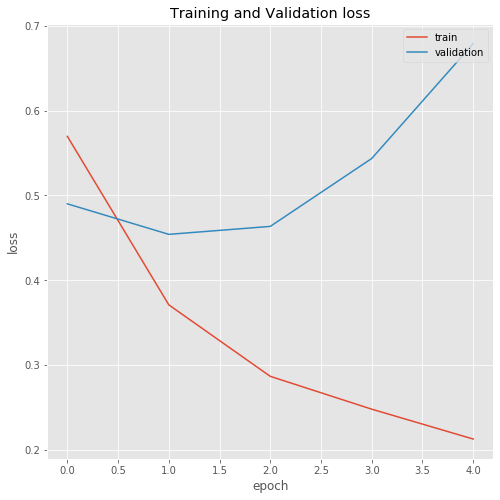

In [32]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [33]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,716,158
Positive,187,439


In [34]:
results

,Value
Accuracy,0.770000
Precision,0.735343
FPR,0.180778
Recall,0.701278
F1,0.717907


# Bidirectional+keras embedding layer

In [35]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1162700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [36]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=32,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])

blstm_keras_embed_model = model.to_json()
with open('./NN_Models/blstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(blstm_keras_embed_model)

model.save_weights('./NN_Models/blstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/50
169/169 [==============================] - 25s 146ms/step - loss: 0.5431 - accuracy: 0.7201 - val_loss: 0.4651 - val_accuracy: 0.7800
Epoch 2/50
169/169 [==============================] - 22s 128ms/step - loss: 0.3588 - accuracy: 0.8576 - val_loss: 0.4358 - val_accuracy: 0.8133
Epoch 3/50
169/169 [==============================] - 19s 113ms/step - loss: 0.2817 - accuracy: 0.8968 - val_loss: 0.5114 - val_accuracy: 0.7983
Epoch 4/50
169/169 [==============================] - 20s 119ms/step - loss: 0.2381 - accuracy: 0.9170 - val_loss: 0.5319 - val_accuracy: 0.7900
Epoch 5/50
169/169 [==============================] - 20s 116ms/step - loss: 0.1925 - accuracy: 0.9307 - val_loss: 0.5554 - val_accuracy: 0.7950
Epoch 00005: early stopping
saved model!


In [37]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,682,192
Positive,160,466


In [38]:
results

,Value
Accuracy,0.765333
Precision,0.708207
FPR,0.219680
Recall,0.744409
F1,0.725857
